In [1]:
import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

In [3]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [17]:
df = pd.read_csv('../data/Original_data/Features_For_Traditional_ML_Techniques.csv')
# df.head(1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134198 entries, 0 to 134197
Data columns (total 64 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Unnamed: 0              134198 non-null  int64  
 1   majority_target         134198 non-null  bool   
 2   statement               134198 non-null  object 
 3   BinaryNumTarget         134198 non-null  float64
 4   tweet                   134198 non-null  object 
 5   followers_count         134198 non-null  float64
 6   friends_count           134198 non-null  float64
 7   favourites_count        134198 non-null  float64
 8   statuses_count          134198 non-null  float64
 9   listed_count            134198 non-null  float64
 10  following               134198 non-null  float64
 11  embeddings              134198 non-null  object 
 12  BotScore                134198 non-null  float64
 13  BotScoreBinary          134198 non-null  float64
 14  cred                

# Check the data validity

In [18]:
# df.head(1)

0-th item tweet text:

"@POTUS Biden Blunders - 6 Month Update

Inflation, Delta mismanagement, COVID for kids, Abandoning Americans in Afghanistan, Arming the Taliban, S. Border crisis, Breaking job growth, Abuse of power (Many Exec Orders, $3.5T through Reconciliation, Eviction Moratorium)...what did I miss?"

It says there're 6 'total_count', 42 'word count', 1 URL, 33% ORG_percentage that do not match the text content. 0 DATE, ORDINAL or CARDINAL percentage -- 6 Month must fall in one of the categories.

In [19]:
# Random datapoint
# df.iloc[10520:10521]

It says: 1 URL, 0 total_count (?), 0 PERSON, 0 LOC (location), 0 CORDINAL, 0 PERCENT, 46 word count, Max word length 14, Min word lenght 1, 3 dots, 0 digits.

In fact: 0 URLs, 38 total_count, word_count  probably should be 34 or 35, 1 location 3 CORDINAL and 1 PERCENT mentions, Max words is 9, Min words is 2, 15 digits, 2 dots.

In [20]:
# df.iloc[80520:80521]

It says there's 1 URL, total_count 1 (that's total number of words), 0 MONEY entity, 0 CARDINAL, 0 TIME, 36 word count, Max word length 14, 0 exclamations, 0 digits, 8 capitals, 0 ampersand, 5 dots.

In fact 0 URL, 54 total_count, 1 Money entity, 2 Cardinal, 1 Percent,1 Time, ~45 word count, the longest word is 'employees' that has 9 characters, several exclamations, 15 capital letters, 2 ampersands, 2 dots (if we count delimiter).

In [9]:
df['Min word length'].max()

1000

<Axes: >

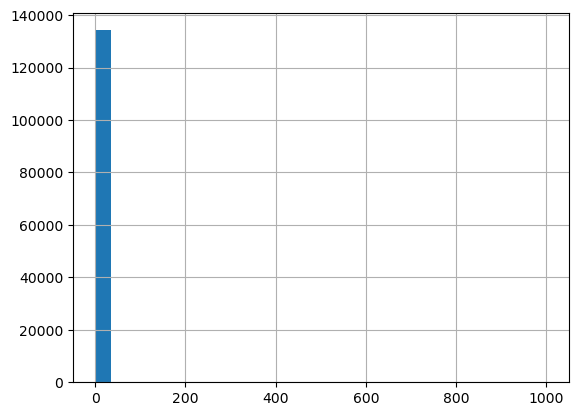

In [10]:
df['Min word length'].hist(bins=30)

So it says there's a tweet where shortest word counts 1000 characters.

In [11]:
df.loc[df['Min word length'].max()]['tweet']

'@sultana_laraib Why this apologetic stance? Being neighbor, Pakistan does have interests in Afghanistan which ought to be defended and advocated. We lost 100,000 civilian lives at the hands of butcher Afghans and many losses worth billion of dollars which we cant forget.'

Word says it's 42.

Ok, long story short. It's not just about these particular datapoints. There are descrepancies across the dataset. I think (and inderectly research team member confirmed that) the team was focused on the NLP analysis, rather than on traditional ML techniques. That ML dataset is kinda bonus. Or maybe something went wrong during data processing. So, anyway, there are descrepancies. 

Unfortunately I was not able to get the correct version from the researchers. So I've come up to the decision to make the recalculations. First I need to count all countable things like quantity of dots, digits, ! and ? signs, number of characters, longest and shortest words and so on.

Then I'll deal with spacy tags. That's a new package for me, so need to get a bit familliar with that.

------------------

But before that, we want to deal with one thing. Although the data types look relevant for the variables, it's unclear why for some of them data type is int64 or float64 – is it that necessary?

The min and max values across the dataset show that there are no extremly large or small numbers there. They can be accomodatetd into a dtypes of smalleer capacities. Like Int32, which is -2,147,483,648 to +2,147,483,647.

We gonna drop "Unnamed 0", since it's a double for index, following, since it's empty. All other variables with dtype int64, except for 'followers_count' will be converted into int32.

------------------

In [12]:
df.describe()

,Unnamed: 0,BinaryNumTarget,followers_count,friends_count,favourites_count,statuses_count,listed_count,following,BotScore,BotScoreBinary,cred,normalize_influence,mentions,quotes,replies,retweets,favourites,hashtags,URLs,unique_count,total_count,ORG_percentage,NORP_percentage,GPE_percentage,PERSON_percentage,MONEY_percentage,DATE_percentage,CARDINAL_percentage,PERCENT_percentage,ORDINAL_percentage,FAC_percentage,LAW_percentage,PRODUCT_percentage,EVENT_percentage,TIME_percentage,LOC_percentage,WORK_OF_ART_percentage,QUANTITY_percentage,LANGUAGE_percentage,Word count,Max word length,Min word length,Average word length,present_verbs,past_verbs,adjectives,adverbs,adpositions,pronouns,TOs,determiners,conjunctions,dots,exclamation,questions,ampersand,capitals,digits,long_word_freq,short_word_freq
count,134198.00000,134198.000000,1.341980e+05,134198.000000,1.341980e+05,1.341980e+05,134198.000000,134198.0,134198.000000,134198.000000,134198.000000,134198.000000,134198.000000,134198.000000,134198.000000,134198.000000,134198.000000,134198.000000,134198.000000,134198.000000,134198.000000,134198.000000,134198.000000,134198.000000,134198.000000,134198.000000,134198.000000,134198.000000,134198.000000,134198.000000,134198.000000,134198.000000,134198.000000,134198.000000,134198.000000,134198.000000,134198.000000,134198.000000,134198.000000,134198.000000,134198.000000,134198.000000,134198.000000,134198.000000,134198.00000,134198.000000,134198.000000,134198.000000,134198.00000,134198.000000,134198.000000,134198.000000,134198.000000,134198.000000,134198.000000,134198.000000,134198.000000,134198.000000,134198.000000,134198.000000
mean,67098.50000,0.513644,1.129308e+04,1893.454455,3.298123e+04,3.419576e+04,73.300198,0.0,0.059106,0.032355,0.405852,0.077665,1.388918,0.573406,1.914201,6.674354,27.572386,0.104726,0.737701,2.365624,3.441229,0.199964,0.067412,0.136151,0.221930,0.029525,0.102339,0.091104,0.030638,0.012432,0.003352,0.005265,0.006839,0.002607,0.005662,0.009771,0.008517,0.002396,0.001011,35.077691,13.062043,1.399857,5.056648,2.452354,1.81221,3.034308,1.575873,3.619644,1.49582,0.788626,0.135583,1.003495,2.366116,0.259408,0.307151,0.121537,12.831905,3.559494,2.249557,21.438658
std,38739.77005,0.499816,4.374971e+05,6997.695671,6.878021e+04,7.510120e+04,1083.274277,0.0,0.167819,0.176942,0.239223,0.026184,1.471604,28.436726,122.041183,406.542579,1831.425703,0.458687,0.439886,1.351617,2.479373,0.276376,0.165502,0.242561,0.298133,0.106880,0.206059,0.190366,0.116949,0.070884,0.037525,0.048690,0.053513,0.032400,0.046830,0.070224,0.062580,0.030757,0.019590,13.604442,3.044782,2.795407,0.825737,2.049247,1.73699,2.012125,1.546382,2.195625,1.63947,0.961242,0.379235,1.086844,2.140459,0.903957,0.774367,0.453865,15.557524,6.674458,2.912136,9.625147
min,0.00000,0.000000,0.000000e+00,0.000000,0.000000e+00,1.000000e+00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33549.25000,0.000000,7.000000e+01,168.000000,1.356000e+03,3.046000e+03,0.000000,0.0,0.030000,0.000000,0.223684,0.061814,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.000000,11.000000,1.000000,4.571429,1.000000,0.00000,2.000000,0.000000,2.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,6.000000,0.000000,1.000000,14.000000
50%,67098.50000,1.000000,3.540000e+02,567.000000,8.377000e+03,1.101900e+04,2.000000,0.0,0.030000,0.000000,0.386691,0.079436,1.00

In [13]:
convert_to_32 = ['friends_count', 'favourites_count', 'statuses_count', 'listed_count', 'following', 'replies', 'retweets', 'favourites']
convert_to_16 = ['mentions', 'quotes',  'hashtags', 'URLs', 'unique_count', 'total_count', 'Word count', 'Max word length', 'Min word length', 'present_verbs', 'past_verbs', 'adjectives', 'adverbs', 'adpositions', 'pronouns', 'TOs', 'determiners', 'conjunctions', 'dots', 'exclamation', 'questions', 'ampersand', 'capitals', 'digits', 'short_word_freq', 'long_word_freq']
convert_to_8 = ['BotScoreBinary', 'BinaryNumTarget']

df[convert_to_32] = df[convert_to_32].astype('int32')
df[convert_to_16] = df[convert_to_16].astype('int16')
df[convert_to_8] = df[convert_to_8].astype('int8')

df.info() shows that size went down from 66Mb to 40Mb. 

Now we'll do the same for floats. For floats it's float32 for 8 digits, float64 is for 16 digits. judging by the info we hardly need a very high precision. So float32 will do for all.

In [14]:
convert_to_float32 = ['BotScore', 'cred', 'normalize_influence', 'Average word length', 'ORG_percentage', 'NORP_percentage', 'GPE_percentage', 'MONEY_percentage', 'DATE_percentage', 'CARDINAL_percentage', 'ORDINAL_percentage', 'FAC_percentage', 'LAW_percentage', 'PRODUCT_percentage', 'EVENT_percentage', 'WORK_OF_ART_percentage', 'QUANTITY_percentage', 'LOC_percentage', 'PERCENT_percentage', 'LANGUAGE_percentage', 'TIME_percentage', 'PERSON_percentage']

df[convert_to_float32] = df[convert_to_float32].astype('float32')

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134198 entries, 0 to 134197
Data columns (total 64 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Unnamed: 0              134198 non-null  int64  
 1   majority_target         134198 non-null  bool   
 2   statement               134198 non-null  object 
 3   BinaryNumTarget         134198 non-null  int8   
 4   tweet                   134198 non-null  object 
 5   followers_count         134198 non-null  float64
 6   friends_count           134198 non-null  int32  
 7   favourites_count        134198 non-null  int32  
 8   statuses_count          134198 non-null  int32  
 9   listed_count            134198 non-null  int32  
 10  following               134198 non-null  int32  
 11  embeddings              134198 non-null  object 
 12  BotScore                134198 non-null  float32
 13  BotScoreBinary          134198 non-null  int8   
 14  cred                

Ok, we reduced the size to 27.5Mb. With dropping the unnecessary variables th size will go even lower.

Now we're gonna drop some unnecessary columns: Unnamed 0, following, embeddings (not sure what's that for considering how it looks), majority_atrget (we're having binary representation).

In [15]:
df.drop(columns=['Unnamed: 0', 'majority_target', 'following', 'embeddings'], inplace=True)


In [16]:
df.shape

(134198, 60)

# Feature recalculations

First we need to set the existing values to 0.

In [22]:
data = df[:10] # just for case

In [23]:
data[['total_count', 'exclamation', 'questions', 'ampersand', 'digits', 'dots', 'capitals', 'URLs', 'Max word length', 'Min word length', 'Average word length']] = 0

In [24]:
# Calculate total_count
data['calculated_total_count'] = data['tweet'].apply(lambda x: len(str(x).split()))
incorrect_counts = data[data['calculated_total_count'] != data['total_count']]
data['total_count'] = data['calculated_total_count']
data = data.drop(columns=['calculated_total_count'])

In [25]:
# exclamation signs
data['exclamation_count'] = data['tweet'].str.count('!')
data['exclamation'] = data['exclamation'] + data['exclamation_count']
data.drop(columns=['exclamation_count'], inplace=True)

In [26]:
# question signs
data['quest_count'] = data['tweet'].str.count('\?')
data['questions'] = data['questions'] + data['quest_count']
data.drop(columns=['quest_count'], inplace=True)

In [27]:
# ampersands
data['feature_count'] = data['tweet'].str.count('&')
data['ampersand'] = data['ampersand'] + data['feature_count']
data.drop(columns=['feature_count'], inplace=True)

In [28]:
# digits
data['digit_count'] = data['tweet'].str.findall(r'\b\d+\.?\d*\b').apply(len)
data['digits'] = data['digit_count']
data.drop(columns=['digit_count'], inplace=True)

In [29]:
# dots
data['feature_count'] = data['tweet'].str.count('\.')
data['dots'] = data['dots'] + data['feature_count']
data.drop(columns=['feature_count'], inplace=True)

In [30]:
# capitals
data['feature_count'] = data['tweet'].str.findall(r'\b[A-Z][a-z]*\b').apply(len)
data['capitals'] = data['capitals'] + data['feature_count']
data.drop(columns=['feature_count'], inplace=True)

In [31]:
# URLs
import re

def recount_urls(text):
    # Improved regex pattern to match various URL formats
    pattern = r'\b(?:http://|https://)?(?:www\.)?[\w.-]+\.[a-z]{2,6}\b(?:/[\w.-]*)*'
    return len(re.findall(pattern, text, re.IGNORECASE))

data['URLs'] = data['tweet'].apply(recount_urls)

In [35]:
# Word length features
import string

In [36]:
# function to find word lengths, we'll use for the next features
def word_lengths(text):
    words = text.split()
    lengths = [len(word.strip(string.punctuation)) for word in words]
    return lengths

In [37]:
# Max word length
data['Max word length'] = data['tweet'].apply(lambda x: max(word_lengths(x)) if word_lengths(x) else 0)

# min word lenggth
data['Min word length'] = data['tweet'].apply(lambda x: min(word_lengths(x)) if word_lengths(x) else 0)

# Avg. word length
data['Average word length'] = data['tweet'].apply(lambda x: sum(word_lengths(x)) / len(word_lengths(x)) if word_lengths(x) else 0)

In [38]:
# hashtags
data['hashtags'] = 0
data['feature_count'] = data['tweet'].str.count('#')
data['hashtags'] = data['hashtags'] + data['feature_count']
data.drop(columns=['feature_count'], inplace=True)

## spacy lexical recalculations

Now to the lexical features.

That's more complex. Took me a while to get it how it words and deal with importing the lib and pipelines. There was not problem with the smaller pipeline, which works faster, but it took some time to setup the larger and more 'accurate' pipeline en_core_web_trf.

In [39]:
import spacy

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
# I don't want to do that 'inplace', so i'll make additional features, then drop the old features.

def count_pos(text):
    doc = nlp(text)
    pos_counts = {
        'present_verbs_g': 0,
        'past_verbs_g': 0,
        'adjectives_g': 0,
        'adverbs_g': 0,
        'adpositions_g': 0,
        'pronouns_g': 0,
        'TOs_g': 0,
        'determiners_g': 0,
        'conjunctions_g': 0
    }
    for token in doc:
        if token.pos_ == 'VERB':
            if token.tag_ in ['VB', 'VBP', 'VBZ']:
                pos_counts['present_verbs_g'] += 1
            elif token.tag_ in ['VBD', 'VBN']:
                pos_counts['past_verbs_g'] += 1
        elif token.pos_ == 'ADJ':
            pos_counts['adjectives_g'] += 1
        elif token.pos_ == 'ADV':
            pos_counts['adverbs_g'] += 1
        elif token.pos_ == 'ADP':
            pos_counts['adpositions_g'] += 1
        elif token.pos_ == 'PRON':
            pos_counts['pronouns_g'] += 1
        elif token.text == 'to':
            pos_counts['TOs_g'] += 1
        elif token.pos_ == 'DET':
            pos_counts['determiners_g'] += 1
        elif token.pos_ == 'CCONJ' or token.pos_ == 'SCONJ':
            pos_counts['conjunctions_g'] += 1
    return pd.Series(pos_counts)

In [ ]:
pos_counts_df = data['tweet'].apply(count_pos)
df = data.join(pos_counts_df)

In [ ]:
# dropppinf old and renaming
data.drop(columns=['present_verbs', 'past_verbs', 'adjectives', 'adverbs', 'adpositions', 'pronouns', 'TOs', 'determiners', 'conjunctions'], inplace=True)

In [ ]:
ren_columns = {'present_verbs_g' : 'present_verbs', 
               'past_verbs_g' : 'past_verbs', 
               'adjectives_g': 'adjectives', 
               'adverbs_g' : 'adverbs', 
               'adpositions_g' : 'adpositions', 
               'pronouns_g' : 'pronouns', 
               'TOs_g' : 'TOs', 
               'determiners_g' : 'determiners', 
               'conjunctions_g' : 'conjunctions' 
              }
data.rename(columns=ren_columns, inplace=True)
data.drop(columns=['present_verbs_g','past_verbs_g','adjectives_g','adverbs_g','adpositions_g','pronouns_g','TOs_g','determiners_g','conjunctions_g'], inplace=True)
# ok that could have been done in a more efficient pythonic way...

#### Now about short/long

I tried to find out what the researchers meant by the short and long words. 5 characters -- is it short or long? 

So I decided to recalculate that too and did a tiny research.

In English a short word is considered to be a word of 3 letters. Then go middle words. And from 7 and up -- the long words. We don't want (for now?) to implement a new feature -- "middle word". So we'll be considering everything starting from 7 as long, axnd below that threshold as short words. 7 is long.

_so say we all_

In [40]:
# tiny test
text = '@POTUS Biden Blunders - 6 Month Update\n\nInflation, Delta mismanagement, COVID for kids, Abandoning Americans in Afghanistan, Arming the Taliban, S. Border crisis, Breaking job growth, Abuse of power (Many Exec Orders, $3.5T through Reconciliation, Eviction Moratorium)...what did I miss?'
w = re.findall(r'\b\w+\b', text)
# w = text.split()
for word in w:
    if word.isalpha() and len(word) >6:
        print(word)

Blunders
Inflation
mismanagement
Abandoning
Americans
Afghanistan
Taliban
Breaking
through
Reconciliation
Eviction
Moratorium


In [44]:
threshold = 7

def count_word_types(text):
    words = re.findall(r'\b\w+\b', text)
    short_words = sum(1 for word in words if word.isalpha() and len(word) < threshold)
    long_words = sum(1 for word in words if word.isalpha() and len(word) >= threshold)
    return pd.Series({
        'short_word_freq': short_words,
        'long_word_freq': long_words
    })

In [48]:
# drop existing columns
data.drop(columns=['long_word_freq','short_word_freq'], inplace=True)

In [49]:
word_counts_df = data['tweet'].apply(count_word_types)
data = data.join(word_counts_df)

# now at least we know what stands behind short and long

### spacy tags recalculation

In [ ]:
# same as before, i want to keep the existing columns and add the new ones to compare the results
def calculate_entity_percentages(text):
    doc = nlp(text)
    total_tokens = len(doc)
    
    entity_counts = {
            'ORG_percent': 0,
            'GPE_percent': 0,
            'MONEY_percent': 0,
            'EVENT_percent': 0,
            'PRODUCT_percent': 0,
            'NORP_percent': 0,
            'WORK_OF_ART_percent': 0,
            'LAW_percent': 0,
            'FAC_percent': 0,
            'CARDINAL_percent': 0,
            'QUANTITY_percent': 0,
            'LANGUAGE_percent': 0,
            'DATE_percent': 0,
            'LOC_percent': 0,
            'ORDINAL_percent': 0,
            'PERCENT_percent': 0,
            'PERSON_percent': 0,
            'TIME_percent': 0
    }
    
    for ent in doc.ents:
        if ent.label_ == 'ORG':
            entity_counts['ORG_percent'] += 1
        elif ent.label_ == 'FAC':
            entity_counts['FAC_percent'] += 1
        elif ent.label_ == 'NORP':
            entity_counts['NORP_percent'] += 1
        elif ent.label_ == 'GPE':
            entity_counts['GPE_percent'] += 1
        elif ent.label_ == 'MONEY':
            entity_counts['MONEY_percent'] += 1
        elif ent.label_ == 'DATE':
            entity_counts['DATE_percent'] += 1
        elif ent.label_ == 'CARDINAL':
            entity_counts['CARDINAL_percent'] += 1
        elif ent.label_ == 'LAW':
            entity_counts['LAW_percent'] += 1
        elif ent.label_ == 'PRODUCT':
            entity_counts['PRODUCT_percent'] += 1
        elif ent.label_ == 'EVENT':
            entity_counts['EVENT_percent'] += 1
        elif ent.label_ == 'WORK_OF_ART':
            entity_counts['WORK_OF_ART_percent'] += 1
        elif ent.label_ == 'QUANTITY':
            entity_counts['QUANTITY_percent'] += 1
        elif ent.label_ == 'LANGUAGE':
            entity_counts['LANGUAGE_percent'] += 1,
        elif ent.label_ == 'LOC':
            entity_counts['LOC_percent'] += 1,
        elif ent.label_ == 'ORDINAL':
            entity_counts['ORDINAL_percent'] += 1,
        elif ent.label_ == 'PERCENT':
            entity_counts['PERCENT_percent'] += 1,
        elif ent.label_ == 'PERSON':
            entity_counts['PERSON_percent'] += 1,
        elif ent.label_ == 'TIME':
            entity_counts['TIME_percent'] += 1
    
    for key in entity_counts.keys():
        entity_counts[key] = (entity_counts[key] / total_tokens) * 100 if total_tokens > 0 else 0
    
    return pd.Series(entity_counts)

In [ ]:
# that took a while to process. Like 8-9 hours.

entity_percentages_df = data['tweet'].apply(calculate_entity_percentages)
data = data.join(entity_percentages_df)

In [ ]:
# now we can drop the old and rename the new columns
data.drop(columns=[
                    'ORG_percentage', 
                    'NORP_percentage', 
                    'GPE_percentage', 
                    'PERSON_percentage', 
                    'MONEY_percentage', 
                    'DATE_percentage', 
                    'CARDINAL_percentage', 
                    'PERCENT_percentage', 
                    'ORDINAL_percentage', 
                    'FAC_percentage', 
                    'LAW_percentage', 
                    'PRODUCT_percentage', 
                    'EVENT_percentage', 
                    'TIME_percentage', 
                    'LOC_percentage', 
                    'WORK_OF_ART_percentage', 
                    'QUANTITY_percentage', 
                    'LANGUAGE_percentage'
                     ], inplace=True)

v3_data.rename(columns={
    'ORG_percent': 'ORG_percentage',
    'NORP_percent': 'NORP_percentage',
    'GPE_percent': 'GPE_percentage',
    'PERSON_percent': 'PERSON_percentage',
    'MONEY_percent': 'MONEY_percentage',
    'DATE_percent': 'DATE_percentage',
    'CARDINAL_percent': 'CARDINAL_percentage',
    'PERCENT_percent': 'PERCENT_percentage',
    'ORDINAL_percent': 'ORDINAL_percentage',
    'FAC_percent': 'FAC_percentage',
    'LAW_percent': 'LAW_percentage',
    'PRODUCT_percent': 'PRODUCT_percentage',
    'EVENT_percent': 'EVENT_percentage',
    'TIME_percent': 'TIME_percentage',
    'LOC_percent': 'LOC_percentage',
    'WORK_OF_ART_percent': 'WORK_OF_ART_percentage',
    'QUANTITY_percent': 'QUANTITY_percentage',
    'LANGUAGE_percent':'LANGUAGE_percentage'
}, inplace=True)

Now after vmaking sure everything looks normal, that all features are recalculaated, that the tags make sense (if there's a person in text or date we can see that in our renewed dataset PERSON and DATE tags reflect that) we can save it as a new dataset to continue work.

In [51]:
pd.reset_option('display.max_colwidth')
pd.reset_option('display.max_columns')

In [30]:
# We can't use .csv as pandas does not preserve the new datatypes, it uses default dtypes, so we save data to parquet
# corrected_file_path = '../data/dataset.parquet'
# df.to_parquet(corrected_file_path, index=False)




# corrected_file_path = '../data/Features_For_Traditional_ML_Techniques_v3.csv'
# data.to_csv(corrected_file_path, index=False)

# corrected_file_path

In [11]:
# # That plot for scaled data. Scale and see how it looks
# plt.scatter(X_train_scaled[:,0], X_train_scaled[:,1])
# plt.title('Linearly separable data')
# plt.xlabel('X1')
# plt.ylabel('X2')
# plt.show();